In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation, RNN
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras import backend as K

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

(1000, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


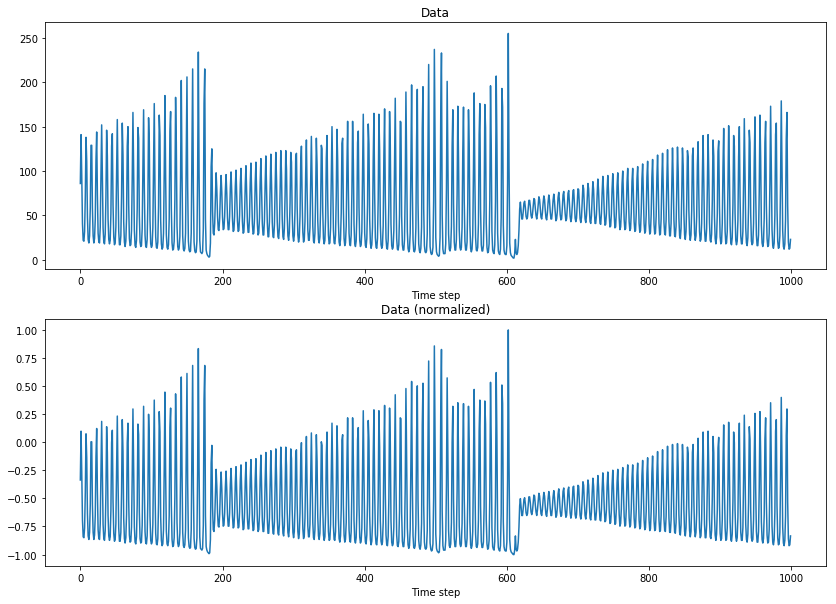

In [23]:
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(212)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [70]:
inputsize = 200

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def get_model():
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=False, input_shape=(trainX.shape[1], 1)))
#     model.add(LSTM(16, return_sequences=False))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
    return model

# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))

# Compare normalized and not normalized data (data/data_normed)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

loadModel = False

if loadModel:
    model = keras.models.load_model("model.h5")
else:
    # Create model
    model = get_model()
    # Train it
    history = model.fit(trainX, trainY, epochs=25, validation_data=(testX, testY), verbose=2, shuffle=False)
    # Save it
    model.save("model.h5")

inputdata Shape (800, 200, 1)
target Shape (800, 1)
trainX.shape (720, 200, 1)
trainY.shape (720, 1)
testX.shape (80, 200, 1)
testY.shape (80, 1)
Train on 720 samples, validate on 80 samples
Epoch 1/25
 - 5s - loss: 0.3578 - acc: 0.0028 - val_loss: 0.4246 - val_acc: 0.0000e+00
Epoch 2/25
 - 2s - loss: 0.3264 - acc: 0.0028 - val_loss: 0.4200 - val_acc: 0.0000e+00
Epoch 3/25
 - 2s - loss: 0.3217 - acc: 0.0028 - val_loss: 0.4152 - val_acc: 0.0000e+00
Epoch 4/25
 - 2s - loss: 0.3178 - acc: 0.0028 - val_loss: 0.4092 - val_acc: 0.0000e+00
Epoch 5/25
 - 2s - loss: 0.3126 - acc: 0.0028 - val_loss: 0.4006 - val_acc: 0.0000e+00
Epoch 6/25
 - 2s - loss: 0.3045 - acc: 0.0028 - val_loss: 0.3847 - val_acc: 0.0000e+00
Epoch 7/25
 - 2s - loss: 0.2947 - acc: 0.0028 - val_loss: 0.3700 - val_acc: 0.0000e+00
Epoch 8/25
 - 2s - loss: 0.2807 - acc: 0.0028 - val_loss: 0.3443 - val_acc: 0.0000e+00
Epoch 9/25
 - 2s - loss: 0.2603 - acc: 0.0000e+00 - val_loss: 0.3063 - val_acc: 0.0000e+00
Epoch 10/25
 - 2s - lo

pred.shape  (80, 1)


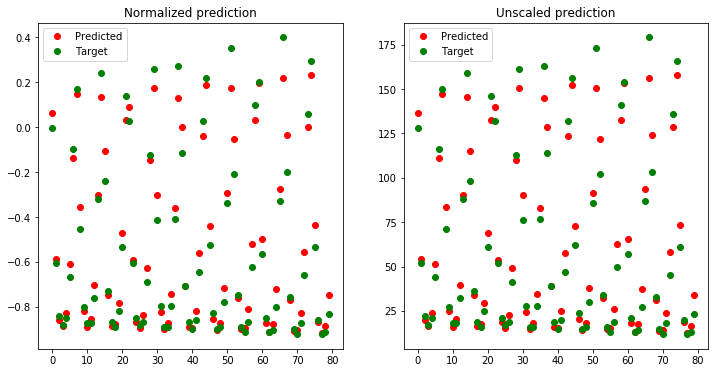

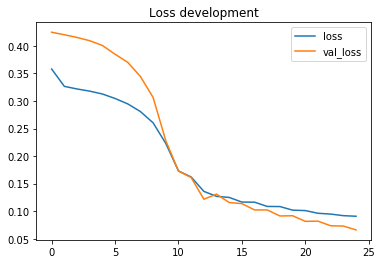

In [71]:
pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

if not loadModel:
    plt.title('Loss development')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

## Predict a timeseries of 200 timesteps recursively

(720, 200, 1)


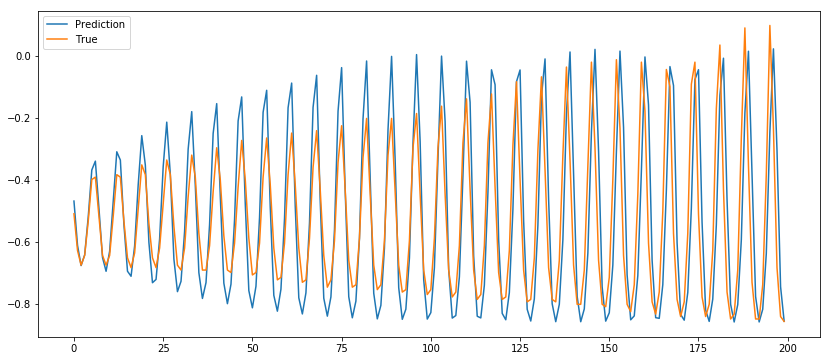

In [75]:
def forecast(model, inp, timesteps=200):
    for i in range(timesteps):
        # make forecast
        pred = model.predict(inp.reshape(1, len(inp),1))
#         print(pred)
        # add it and use it as new input
        inp = np.append(inp, pred)
        inp = inp[-inputsize:]
    return inp[-timesteps:]

print(trainX.shape)
i = 488
forecast_pred = forecast(model, trainX[i], 200)
true_forecast = trainX[i+200][-200:]
plt.figure(figsize=(14,6))
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()

## Try to implement K-Fold crossvalidation and save the n-best models to use as ensemble

In [76]:
def save_models(models):
    for i, m in enumerate(models):
        m.save(f"models/model{i}.h5")
    print("Saved models")

def load_models():
    files = os.listdir("models")
    models = []
    for f in files:
        print("Load model: ", f)
        loaded_model = keras.models.load_model(f"models/{f}")
        models.append(loaded_model)
    return models

loadModels = True

if loadModels:
    models = load_models()
else:
    models = []
    n_folds = 10
    kf = KFold(n_splits=n_folds)
    iteration = 0
    for train_index, test_index in kf.split(inputdata, target):
        trainX, trainY = inputdata[train_index], target[train_index]
        testX, testY = inputdata[test_index], target[test_index]

        # Create model
        model = get_model()
        # Train it
        history = model.fit(trainX, trainY, epochs=25, validation_split=0.1, verbose=2)
        # Save it
        model.save(f"models/model{iteration}.h5")

        models.append(model)
        score = model.evaluate(testX, testY)[0]
        print(f'Iteration: {iteration} with score: {score}')
        iteration += 1

Train on 648 samples, validate on 72 samples
Epoch 1/25
 - 5s - loss: 0.4677 - acc: 0.0000e+00 - val_loss: 0.4267 - val_acc: 0.0000e+00
Epoch 2/25
 - 2s - loss: 0.3784 - acc: 0.0031 - val_loss: 0.4251 - val_acc: 0.0000e+00
Epoch 3/25
 - 2s - loss: 0.3678 - acc: 0.0031 - val_loss: 0.4207 - val_acc: 0.0000e+00
Epoch 4/25
 - 2s - loss: 0.3627 - acc: 0.0031 - val_loss: 0.4169 - val_acc: 0.0000e+00
Epoch 5/25
 - 2s - loss: 0.3615 - acc: 0.0031 - val_loss: 0.4115 - val_acc: 0.0000e+00
Epoch 6/25
 - 2s - loss: 0.3583 - acc: 0.0031 - val_loss: 0.4042 - val_acc: 0.0000e+00
Epoch 7/25
 - 2s - loss: 0.3492 - acc: 0.0031 - val_loss: 0.3914 - val_acc: 0.0000e+00
Epoch 8/25
 - 2s - loss: 0.3330 - acc: 0.0031 - val_loss: 0.3728 - val_acc: 0.0000e+00
Epoch 9/25
 - 2s - loss: 0.3224 - acc: 0.0015 - val_loss: 0.3503 - val_acc: 0.0000e+00
Epoch 10/25
 - 2s - loss: 0.2927 - acc: 0.0015 - val_loss: 0.2907 - val_acc: 0.0000e+00
Epoch 11/25
 - 2s - loss: 0.2237 - acc: 0.0000e+00 - val_loss: 0.1500 - val_acc:

 - 2s - loss: 0.1879 - acc: 0.0000e+00 - val_loss: 0.1413 - val_acc: 0.0000e+00
Epoch 13/25
 - 2s - loss: 0.1423 - acc: 0.0000e+00 - val_loss: 0.1329 - val_acc: 0.0000e+00
Epoch 14/25
 - 2s - loss: 0.1331 - acc: 0.0000e+00 - val_loss: 0.1190 - val_acc: 0.0000e+00
Epoch 15/25
 - 2s - loss: 0.1274 - acc: 0.0000e+00 - val_loss: 0.1014 - val_acc: 0.0000e+00
Epoch 16/25
 - 2s - loss: 0.1222 - acc: 0.0000e+00 - val_loss: 0.1104 - val_acc: 0.0000e+00
Epoch 17/25
 - 2s - loss: 0.1150 - acc: 0.0000e+00 - val_loss: 0.0889 - val_acc: 0.0000e+00
Epoch 18/25
 - 2s - loss: 0.1106 - acc: 0.0000e+00 - val_loss: 0.0902 - val_acc: 0.0000e+00
Epoch 19/25
 - 2s - loss: 0.1060 - acc: 0.0000e+00 - val_loss: 0.0856 - val_acc: 0.0000e+00
Epoch 20/25
 - 2s - loss: 0.1011 - acc: 0.0000e+00 - val_loss: 0.0677 - val_acc: 0.0000e+00
Epoch 21/25
 - 2s - loss: 0.0935 - acc: 0.0000e+00 - val_loss: 0.0839 - val_acc: 0.0000e+00
Epoch 22/25
 - 2s - loss: 0.0814 - acc: 0.0000e+00 - val_loss: 0.0632 - val_acc: 0.0000e+00


Epoch 23/25
 - 2s - loss: 0.1090 - acc: 0.0015 - val_loss: 0.0617 - val_acc: 0.0000e+00
Epoch 24/25
 - 2s - loss: 0.1024 - acc: 0.0015 - val_loss: 0.0950 - val_acc: 0.0000e+00
Epoch 25/25
 - 2s - loss: 0.1126 - acc: 0.0015 - val_loss: 0.0633 - val_acc: 0.0000e+00
80/80 [==============================] - 0s 637us/step
Iteration: 6 with score: 0.04066991880536079
Train on 648 samples, validate on 72 samples
Epoch 1/25
 - 6s - loss: 0.5499 - acc: 0.0000e+00 - val_loss: 0.4291 - val_acc: 0.0000e+00
Epoch 2/25
 - 2s - loss: 0.3793 - acc: 0.0031 - val_loss: 0.4185 - val_acc: 0.0000e+00
Epoch 3/25
 - 2s - loss: 0.3647 - acc: 0.0015 - val_loss: 0.4150 - val_acc: 0.0000e+00
Epoch 4/25
 - 2s - loss: 0.3615 - acc: 0.0031 - val_loss: 0.4120 - val_acc: 0.0000e+00
Epoch 5/25
 - 2s - loss: 0.3587 - acc: 0.0031 - val_loss: 0.4084 - val_acc: 0.0000e+00
Epoch 6/25
 - 2s - loss: 0.3529 - acc: 0.0031 - val_loss: 0.4035 - val_acc: 0.0000e+00
Epoch 7/25
 - 2s - loss: 0.3504 - acc: 0.0031 - val_loss: 0.3956 

> 1: single=0.072, ensemble=0.005
> 2: single=0.055, ensemble=0.004
> 3: single=0.069, ensemble=0.004
> 4: single=0.050, ensemble=0.003
> 5: single=0.093, ensemble=0.003
> 6: single=0.057, ensemble=0.003
> 7: single=0.062, ensemble=0.003
> 8: single=0.062, ensemble=0.003
> 9: single=0.062, ensemble=0.003
> 10: single=0.056, ensemble=0.003
MSE 0.064 (0.012)


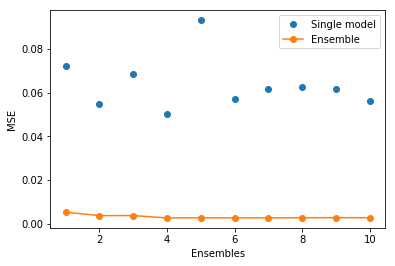

In [80]:
def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    # median across ensemble members
    result = np.mean(yhats, axis=0)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(models, n_models, testX, testy):
    # select a subset of members
    subset = models[:n_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return mean_squared_error(testy, yhat)

def forecast_ensemble(models, inp, timesteps=200):
    for i in range(timesteps):
        # make forecast
        pred = ensemble_predictions(models, inp.reshape(1, len(inp),1))
        # add it and use it as new input
        inp = np.append(inp, pred)
        inp = inp[-inputsize:]
    return inp[-timesteps:]
    

validationX, validationY = testX, testY
single_MSEs, ensemble_MSEs = [], []
for i in range(1, len(models)+1):
    ensemble_MSE = evaluate_n_members(models, i, validationX, validationY)
    single_MSE, _ = models[i-1].evaluate(validationX, validationY, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_MSE, ensemble_MSE))
    ensemble_MSEs.append(ensemble_MSE)
    single_MSEs.append(single_MSE)
# plot score vs number of ensemble members
print('MSE %.3f (%.3f)' % (np.mean(single_MSEs), np.std(single_MSEs)))
x_axis = [i for i in range(1, len(models)+1)]
plt.plot(x_axis, single_MSEs, marker='o', linestyle='None', label='Single model')
plt.plot(x_axis, ensemble_MSEs, marker='o', label="Ensemble")
plt.ylabel('MSE')
plt.xlabel('Ensembles')
plt.legend()
plt.show()


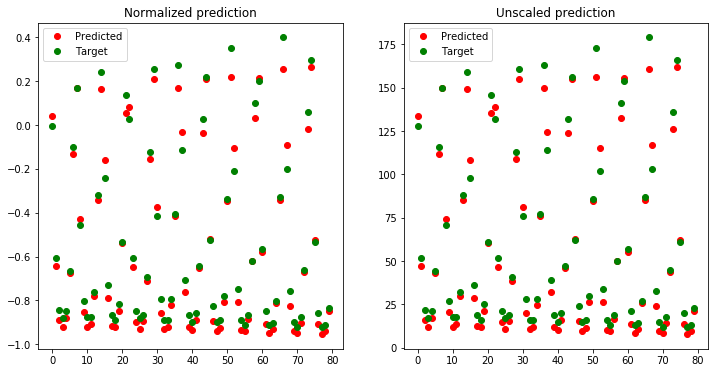

MSE:  0.0025661442388869547
(720, 200, 1)


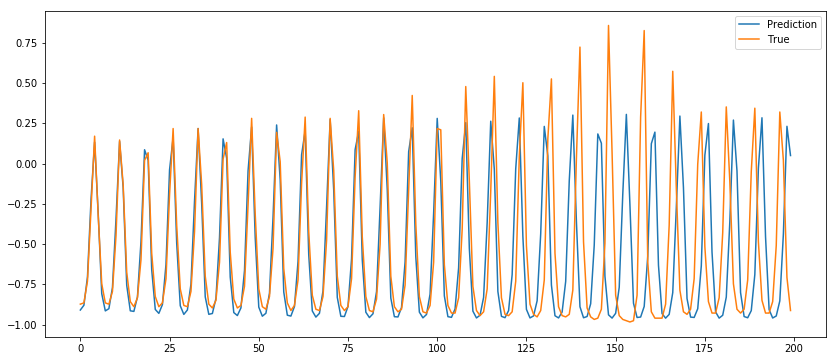

In [88]:
pred = ensemble_predictions(models[:4], testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

print("MSE: ", mean_squared_error(testY, pred))

print(trainX.shape)
i = 150
forecast_pred = forecast_ensemble(models, trainX[i], 200)
true_forecast = trainX[i+200][-200:]
plt.figure(figsize=(14,6))
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()